In [2]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib_inline
from IPython import display
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Parametric study of ANN model and number of nodes in the hidden layer(s)
- Will not be tracking losses or by epoch accuracy. Does not matter how model performance changes through training.
- Will need to track resulting / final accuracy of model, and how this changes with the number of nodes in the hidden layer(s).

***
## Importing and re-structuring data

In [3]:
# importing iris dataset (included in seaborn)
iris = sns.load_dataset('iris')

In [4]:
# re-structuring or transforming data
# converting from pandas dataframe to pytorch tensor
t_dataset= torch.tensor(iris[iris.columns[0:4]].values).float() # only use first 4 columns, because last column is outcome variable or datatype.

# numeric transformation - transforming species name to a number (0-2)
labels = torch.zeros(len(t_dataset), dtype=torch.long) # species 'setosa' will remain 0.
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

***
## Building and training model

In [5]:
# building model
def ANN_classify_build(m_learing_rate=0.01, n_hidden_layers=10):
    ANN_iris = nn.Sequential(
        nn.Linear(4,n_hidden_layers),              # input
        nn.ReLU(),                                 # non-linear activation
        nn.Linear(n_hidden_layers,n_hidden_layers),# hidden layer
        nn.ReLU(),                                 # non-linear activation
        nn.Linear(n_hidden_layers,3)               # output
    )

    # loss function
    loss_func = nn.CrossEntropyLoss() # final activation layer, implements log softmax and NLLLoss

    # optimizer
    model_optimizer = torch.optim.SGD(ANN_iris.parameters(), lr=m_learing_rate)

    return ANN_iris, loss_func, model_optimizer

In [6]:
# training function

def ANN_classify_training(model, loss_function, m_optimizer, input_data, input_labels, epochs = 1000):
    
    # training
    for epoch_IDX in range(epochs):
        # forward pass
        y_hat = model(input_data)

        # calculating loss
        loss = loss_function(y_hat, input_labels) # not graphing for this experiment

        # backprop
        m_optimizer.zero_grad()
        loss.backward()
        m_optimizer.step()

    # final forward pass
    final_predictions = model(input_data)

    # overall accuracy is that is needed for this experiment
    predicted_lables = torch.argmax(final_predictions, axis=1)
    total_accuracy = 100*torch.mean((predicted_lables==input_labels).float())

    return total_accuracy

***
## Setting up and running parametric experiment

In [9]:
epochs = 300
number_hidden_units = np.arange(1,129) # has exclusive upper bound: [1,129). Only actually goes to 128.
total_accuracies = []

for number_units in number_hidden_units:
    # building model
    p_ANN_iris, p_loss_func, p_model_optim = ANN_classify_build(0.01, number_units)

    # training model
    model_accuracy = ANN_classify_training(p_ANN_iris, p_loss_func, p_model_optim, t_dataset, labels, epochs)
    total_accuracies.append(model_accuracy) # storing list of overall accuracy for each number of units

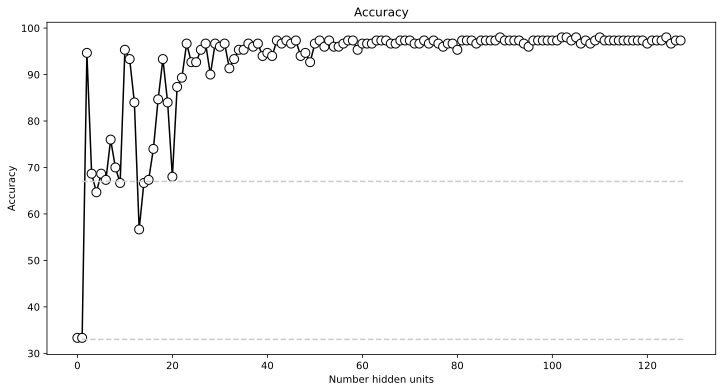

In [10]:
# plotting results

fig,ax = plt.subplots(1,figsize=(12,6))

ax.plot(total_accuracies, 'ko-', markerfacecolor='w', markersize=9)
ax.plot(number_hidden_units[[0,-1]],[33,33], '--', color=[0.8,0.8,0.8]) # horizontal line for categorizing 1 category
ax.plot(number_hidden_units[[0,-1]],[67,67], '--', color=[0.8,0.8,0.8]) # horizontal line for categorizing 2 categories

ax.set_title('Accuracy')
ax.set_xlabel('Number hidden units')
ax.set_ylabel('Accuracy')

plt.show()

### Interpreting the results
- The lowest dashed line at 33 shows that the model could not figure out how to classify the data.
    - It only got the correct category 1/3rd of the time.
    - It is just guessing.
    - The model is not **complex** enough to be able to solve the problem.
    - Tried doing 500 epochs instead of 150, this improved performance for models with less layers.
        - Before at **150** epochs, models with hidden units > 60 performed above the 2/3's accuracy line.
        - At **300** epochs, models with hidden units > 30 performed close to 95% accuracy.
        - At **500** epochs, models with hidden units > 20 performed close to 97% accuracy. 

- The middle line around 67 shows that the model correctly categorized data 2/3rds of the time.
    - This is better than chance. 
    - The model was able to figure out relationships for 2 out of 3 categories.
- The models around 90% accuracy and above successfully figured out the relationship for each category.

**My thoughts**
- Why are there some numbers of nodes that work better than others.
- I'm especially interested with the range of 20-80 nodes / hidden layer.
    - Why is this range so unstable?
    - Why does it get better with more layers?
- Factors like learning rate and number of epochs could also affect how many hidden layers are needed.